# Understanding linear regression when m < n -- when you do want model selectoin

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

Let us first generate data

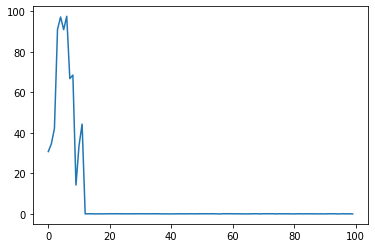

In [27]:
m_train, m_test = 60, 50  #number of samples

n = 100 #number of features

theta_true = np.linspace(10, 20, n)

mu_x = np.linspace(1, 10, n)
approx_rank = 12 ##approx rank because first approx_rank singular values are high. 
eig_vals = np.concatenate((100 * np.random.rand(approx_rank), 0.1*np.random.rand(n - approx_rank)))

#eig_vals is a full rank matrix, but most of its energy is only along "approx_rank directions"
tmp = np.random.randn(n,n)
#eig_vals = 100 * np.random.rand(n)


#matlab has a sqrtm function that does matrix square root

X_train = np.random.randn(m_train, n) @ np.sqrt(np.diag(eig_vals)) @ tmp.T + mu_x.T ##matrix square root and element-wise square roots are completely different things 
Y_train = X_train @ theta_true + 1e-3 * np.random.randn(m_train)

X_test = np.random.randn(m_test, n) @ np.sqrt(np.diag(eig_vals)) @ tmp.T + mu_x.T
Y_test = X_test @ theta_true + 1e-3 * np.random.randn(m_test)

plt.plot(eig_vals)
plt.show()

Linear Regression -- all this code is from the second recitation

Final Loss is  137.22443404647188


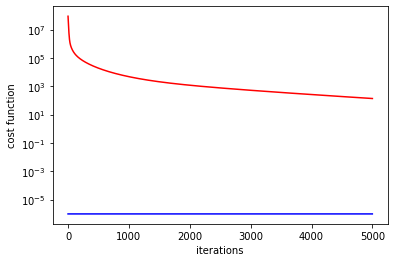

In [20]:
def cost_function(theta, X, y):   
    """
    Inputs: 
        theta: this is the parameter vector of size (n x 1)
        x: this is the input training sample of size (m x n)
        y: this is the output training sample of size (m x 1)
        
    Outputs: 
        cost_function(theta, x, y): the "loss" incurred under current value of parameter
    """
    m, n = X.shape
    yhat = np.dot(X, theta)
    return 1/m * np.linalg.norm( np.squeeze(y) - np.squeeze(yhat), 2) ** 2 #1/m\| y - theta^T x\|_2^2

def cost_gradient(theta, x, y):   
    """
    Inputs: 
        theta: this is the parameter vector of size (n x 1)
        x: this is the input training sample of size (1 x n)
        y: this is the output training sample of size (1 x 1)
        
    Outputs: 
        cost_gradient(theta, x, y): the gradient of cost evaluated at parameter theta
    """
    #np squeeze removes all dimensions whose value is 1: so if you have (1, n, 1, 1) ---> (n, )
    yhat = np.squeeze(x).dot(np.squeeze(theta)) #using squeeze because sometimes when I use this in code, i end up passing (n,1) (n,), (1, n)
    return 2 * (yhat  - y) * x.T  #\Del_{\theta} J(\theta) = (theta^T x - y)x^T


def gradient_descent(X, y, theta_init, max_iter=1000, step_size = 1e-2): #hyperparameters for gradient descent are max iter and step sizr
    theta_list = [theta_init]
    m, n = X.shape
    for _ in range(max_iter):
        grad = 0
        for ii in range(m):
            grad += cost_gradient(theta_init, X[ii:ii+1, :], y[ii]) #evaluates gradient for EACH sample and not the entire dataset! 
            
        theta_new  = theta_init - step_size * grad / m #update rule for theta
        theta_init = theta_new
        #theta -= step_size * grad / m
        theta_list.append(theta_new) 
    return np.squeeze(np.array(theta_list))


#function to compute errrors (nice plots)
def error_vals(X, y, theta_list):
    max_iter = theta_list.shape[0]
    err = []
    for ii in range(max_iter):
        err_tmp = cost_function(theta_list[ii], X, y) #remember that cost_function i am using entire dataset
        err.append(err_tmp)
    return err


max_iter = 5000
step_size = 1e-5


#error plateus at approximately 1e3

theta_list = gradient_descent(X_train, Y_train, np.random.randn(n,1), max_iter, step_size)
cost_decay = error_vals(X_train, Y_train, theta_list)

print("Final Loss is ", cost_decay[-1])
plt.plot(cost_decay, 'r', range(max_iter), [cost_function(theta_true, X_train, Y_train)] * max_iter, 'b')
plt.yscale("log")
plt.xlabel('iterations')
plt.ylabel('cost function')
plt.show()

It seems like we can't do better than this. Let us try "model selection". Let us try PCA! 

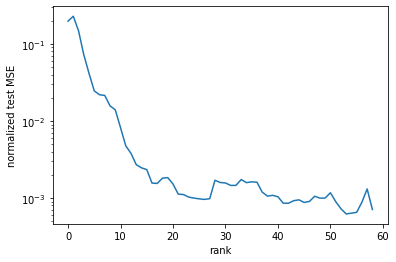

In [28]:
#define a function for normalized MSE 

def normalized_mse(y_true, y_hat):
    return np.linalg.norm(y_true - y_hat, 2) ** 2 / (np.linalg.norm(y_true, 2) **2)


err_norm_mse = np.zeros(m_train-1)

for r in range(1, m_train):
    
    ##PCA in general mean subtraction is very important. 
    #if mean is not subtracted -- then the first principal component (eigenvector corresponding to the largest eigenvalue ) will not give great results
    #largest eigenvalue corresponds to the mean in this case! 
    
    mu_hat = np.mean(X_train, axis=0) #empirical mean computed from training data
    Z = X_train - mu_hat ##using broadcasting rules


    [U_full, S_full, V_full] = np.linalg.svd(Z) #since the "data" is along rows, V_full corresponds to the principal components
    #and U * S will correspond to "scores" -- these are a metric of how close the true data is to the "compressed data"
    
    
    V = V_full[:, :r] #top r principal components since SVD orders singular values in decreasing order
    B = X_train @ V ##kind of like a compressed version of the data. 
    
    # X_train * V \approx u_full * S_full * V_full.T * V  \approx U_full * S_full

    B_tilde = np.hstack((np.ones((60,1)), B)) ##proxy/compressed version of X

    #linear regression on the compressed data
    #could use gradient descent here as well but have to tune hyperparameters 
    #pseudo inverse is fast enough for small data
    
    theta_hat_full = np.linalg.pinv(B_tilde) @ Y_train


    #extract bias part and the rest
    bias_hat = theta_hat_full[0]
    theta_hat = theta_hat_full[1:]

    #finally predict
    #original linear regression -- y_test = X_test * theta_hat, where theta_hat was learned from training data (X_train). 
    y_hat_test = X_test @ V @ theta_hat + bias_hat ##kind of undoing the compression (verify through SVDs!)
    
    #another way to think about this is that prediction is also projecting the test data onto subspace V. 
    err_norm_mse[r-1] = normalized_mse(Y_test, y_hat_test) 

plt.plot(err_norm_mse)
plt.yscale("log")
plt.xlabel('rank')
plt.ylabel('normalized test MSE')
plt.show()


#to get a better plot, incease m and also run monte carlo
#the plot should look like a U shape

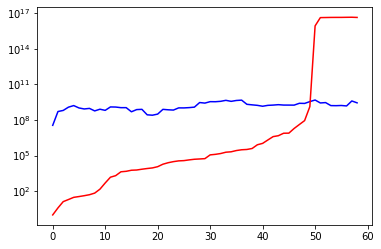

In [29]:
#Bias Variance Tradeoff

biases = np.zeros(m_train-1)
variances = np.zeros(m_train-1)
for r in range(1, m_train):
    
    mu_hat = np.mean(X_train, axis=0)
    Z = X_train - mu_hat ##using broadcasting rules


    [U_full, S_full, V_full] = np.linalg.svd(Z)
    V = V_full[:, :r]
    B = X_train @ V

    B_tilde= np.hstack((np.ones((60,1)), B))

    theta_hat_full = np.linalg.pinv(B_tilde) @ Y_train


    bias_hat = theta_hat_full[0]
    theta_hat = theta_hat_full[1:]

    y_hat_test = X_test @ V @ theta_hat + bias_hat
    
    tmp_bias = 0
    tmp_var = 0
    
    pinv_matrix = X_test[:, :r].T @ X_test[:, :r]
    [u_tmp, s_tmp, v_tmp] = np.linalg.svd(pinv_matrix)
    
    for ii in range(m_test):
        x_test = X_test[ii:ii+1, :r]
        y_test = Y_test[ii]
        tmp_bias += np.dot(np.squeeze(x_test), np.squeeze(theta_true[:r]) - np.squeeze(theta_hat)) ** 2
        tmp_var += np.linalg.norm(x_test, 2) ** 2 / s_tmp[-1]  
    biases[r-1] = tmp_bias
    variances[r-1] = tmp_var

    
plt.figure
plt.plot(biases, 'b', variances, 'r')
plt.yscale("log")
plt.show()